<a href="https://colab.research.google.com/github/msestero/2048/blob/main/Stock_%26_Crypto_Price_Movement_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

These are the variables that I will use to access the data.

In [1]:
stocks_url = "https://data.alpaca.markets/v2/stocks"
crypto_url = "https://data.alpaca.markets/v1beta1/crypto"

API_KEY = "PKEN88T2H7KR0DCO9JMO"
SECRET_KEY = "e9txU1aM8cvzu06GMWqpHt58DA8xJjABjiYEpFae"

In [2]:
import pandas as pd
import requests
import json

headers = {"APCA-API-KEY-ID" : API_KEY,
           "APCA-API-SECRET-KEY" : SECRET_KEY}

In [3]:
def createDay(day):
  date = day.index[0]
  d = {}
  day.set_index("hour", inplace=True)
  for hour in day.index:
    d[hour] = day.loc[hour]["percent_change"]
  d["day"] = date
  return pd.DataFrame(d, index=[0])

In [4]:
def stock_data_year(ticker, year):

  start_date = str(year) + "-01-01"
  end_date = str(year + 1) + "-01-01"
  if year == 2022:
    end_date = "2022-03-11"

  response = requests.get(stocks_url + "/" + ticker + "/bars?start=" + start_date + "&end=" + end_date + "&timeframe=1Day&limit=10000", headers=headers)
  df_day = pd.DataFrame.from_dict(json.loads(response.text)["bars"])
  df_day = df_day.rename(columns={"t": "day", "o" : "open", "h" : "high", "l" : "low", "c": "close", "v" : "volume"})
  df_day["day"] = df_day["day"].map(lambda x : x[:10])
  df_day["percent_change"] = ((df_day["close"] - df_day["open"]) / df_day["open"]) * 100
  df_day.set_index("day", inplace=True)

  response = requests.get(stocks_url + "/" + ticker + "/bars?start=" + str(year) + "-01-01&end=" + end_date + "&timeframe=1Hour&limit=10000", headers=headers)
  df_hr = pd.DataFrame.from_dict(json.loads(response.text)["bars"])
  df_hr = df_hr.rename(columns={"t": "day", "o" : "open", "h" : "high", "l" : "low", "c": "close", "v" : "volume"})
  df_hr["percent_change"] = ((df_hr["close"] - df_hr["open"]) / df_hr["open"]) * 100
  df_hr["hour"] = df_hr["day"].map(lambda x : x[11:13])
  df_hr["day"] = df_hr["day"].map(lambda x : x[:10])
  df_hr.set_index("day", inplace=True)

  days = []
  for index in df_day.index:
    day = df_hr.loc[index, ["percent_change", "hour"]]
    day["hour"] = day["hour"].map(lambda x : "hour_" + str(x) + "_change")
    days.append(day)

  hourly_changes = pd.concat(list(pd.Series(days).map(createDay)), ignore_index=True)
  return pd.merge(hourly_changes.fillna(0), df_day, on=["day"]).set_index("day")

In [5]:
def crypto_data_year(ticker, year):
  
  start_date = str(year) + "-01-01"
  end_date = str(year + 1) + "-01-01"
  if year == 2022:
    end_date = "2022-03-13"

  response = requests.get(crypto_url + "/" + ticker + "/bars?start=" + start_date + "&end=" + end_date + "&timeframe=1Day&limit=10000&exchanges=CBSE", headers=headers)
  df_day = pd.DataFrame.from_dict(json.loads(response.text)["bars"])
  df_day = df_day.drop(columns=["x"])
  df_day = df_day.rename(columns={"t": "day", "o" : "open", "h" : "high", "l" : "low", "c": "close", "v" : "volume"})
  df_day["day"] = df_day["day"].map(lambda x : x[:10])
  df_day["percent_change"] = ((df_day["close"] - df_day["open"]) / df_day["open"]) * 100
  df_day.set_index("day", inplace=True)

  response = requests.get(crypto_url + "/" + ticker + "/bars?start=" + str(year) + "-01-01&end=" + end_date + "&timeframe=1Hour&limit=10000&exchanges=CBSE", headers=headers)
  df_hr = pd.DataFrame.from_dict(json.loads(response.text)["bars"])
  df_hr = df_hr.drop(columns=["x"])
  df_hr = df_hr.rename(columns={"t": "day", "o" : "open", "h" : "high", "l" : "low", "c": "close", "v" : "volume"})
  df_hr["percent_change"] = ((df_hr["close"] - df_hr["open"]) / df_hr["open"]) * 100
  df_hr["hour"] = df_hr["day"].map(lambda x : x[11:13])
  df_hr["day"] = df_hr["day"].map(lambda x : x[:10])
  df_hr.set_index("day", inplace=True)

  days = []
  for index in df_day.index:
    if index in df_hr.index:
      day = df_hr.loc[index, ["percent_change", "hour"]]
      if isinstance(day["hour"], pd.Series):
        day["hour"] = day["hour"].map(lambda x : "hour_" + str(x) + "_change")
        days.append(day)

  hourly_changes = pd.concat(list(pd.Series(days).map(createDay)), ignore_index=True)
  return pd.merge(hourly_changes.fillna(0), df_day, on=["day"]).set_index("day")

In [6]:
def stock_data_years(ticker, years):
  year_datas = []
  for year in years:
    year_datas.append(stock_data_year(ticker, year))
  return pd.concat(year_datas).fillna(0)

def crypto_data_years(ticker, years):
  year_datas = []
  for year in years:
    year_datas.append(crypto_data_year(ticker, year))
  return pd.concat(year_datas).fillna(0)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
import numpy as np

def create_train_test(df_train_year, df_test_year):
  usableColumns = list(set(list(df_train_year)).intersection(set(list(df_test_year))))
  X_train = df_train_year[usableColumns].iloc[:len(df_train_year.index) - 2]
  y_train = df_train_year.iloc[1:len(df_train_year.index) - 1]["percent_change"]

  X_test = df_test_year[usableColumns].iloc[:len(df_test_year.index) - 2]
  y_test = df_test_year.iloc[1:len(df_test_year.index) - 1]["percent_change"]
  return X_train, y_train, X_test, y_test

def create_linear_model(X_train, y_train):
  model = LinearRegression()
  model.fit(X=X_train, y=y_train)
  return model

def plot_predictions(model, X_test, y_test, ticker):
  prediction = pd.Series(model.predict(X=X_test), index=y_test.index, name="predicted_change")
  actual = y_test.rename("actual_change")
  pd.concat([prediction, actual], axis=1).plot.line(title="Linear Model " + ticker + " daily % change predictions vs actual")

In [8]:
def money_df(model, X_test, y_test, ticker, model_type):
  tot = [1000]
  all = [1000]
  for buy, change in zip(model.predict(X_test), y_test):
    if buy > 0:
      tot.append(tot[-1] * (1 + (change / 100)))
    else:
      tot.append(tot[-1])
    all.append(all[-1] * (1 + (change / 100)))
  all = all[:-1]
  tot = tot[:-1]
  model_ret = pd.Series(tot, index=X_test.index, name="model_return")
  stock_ret = pd.Series(all, index=X_test.index, name="stock_return")
  pd.concat([model_ret, stock_ret], axis=1).plot.line(title=model_type + " " + ticker + " return on $1000 ")
  print("stock turned $1000 into $" + str(all[-1]))
  print("model turned $1000 into $" + str(tot[-1]))


In [9]:
def create_neigh_model(X_train, y_train):
  pipeline = make_pipeline(
      StandardScaler(),
      KNeighborsClassifier(n_neighbors=17)
  )
  grid_search = GridSearchCV(
    pipeline,
    param_grid={"kneighborsclassifier__n_neighbors": range(2, min(50, int(len(X_train.index) - 1)))},
    scoring="f1_macro",
    cv=10
  )

  grid_search.fit(X=X_train, y=(y_train > 0))
  n = grid_search.best_params_["kneighborsclassifier__n_neighbors"]
  pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=n)
  )
  pipeline.fit(X=X_train, y=(y_train > 0))
  return pipeline

In [10]:
def predict_stock(ticker):
  df_train_year = stock_data_years(ticker, range(2020, 2022))
  df_test_year = stock_data_year(ticker, 2022)
  X_train, y_train, X_test, y_test = create_train_test(df_train_year, df_test_year)
  model = create_linear_model(X_train, y_train)
  plot_predictions(model, X_test, y_test, ticker)
  money_df(model, X_test, y_test, ticker, "Linear Model")
  model = create_neigh_model(X_train, y_train)
  money_df(model, X_test, y_test, ticker, "KNeighbor Model")

def predict_crypto(ticker):
  df_train_year = crypto_data_years(ticker, range(2020, 2022))
  df_test_year = crypto_data_year(ticker, 2022)
  X_train, y_train, X_test, y_test = create_train_test(df_train_year, df_test_year)
  model = create_linear_model(X_train, y_train)
  plot_predictions(model, X_test, y_test, ticker)
  money_df(model, X_test, y_test, ticker, "Linear Model")
  model = create_neigh_model(X_train, y_train)
  money_df(model, X_test, y_test, ticker, "KNeighbor Model")

stock turned $1000 into $931.4422980275211
model turned $1000 into $943.439229717422
stock turned $1000 into $931.4422980275211
model turned $1000 into $1006.0564958420781


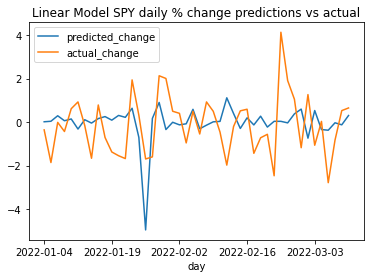

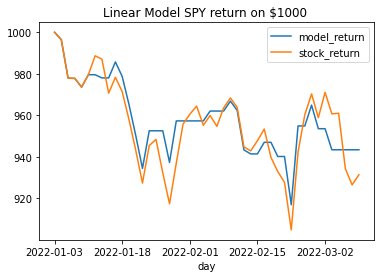

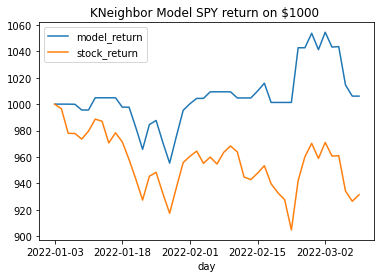

In [11]:
predict_stock("SPY")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stock turned $1000 into $954.969594320058
model turned $1000 into $992.7443959484398
stock turned $1000 into $954.969594320058
model turned $1000 into $985.8034938101193


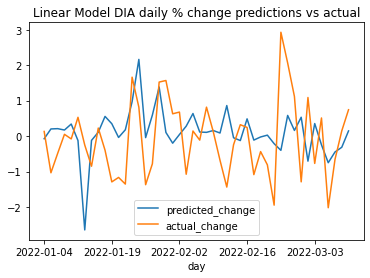

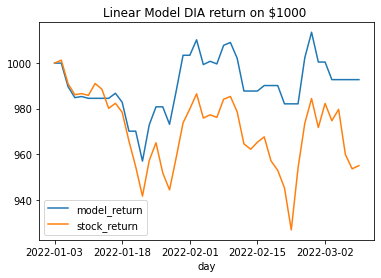

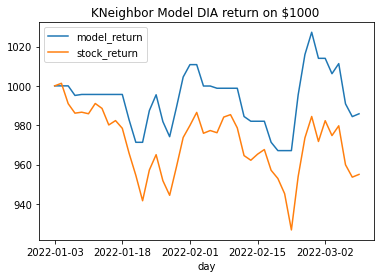

In [12]:
predict_stock("DIA")

stock turned $1000 into $856.1048865865645
model turned $1000 into $1216.7531489847293
stock turned $1000 into $856.1048865865645
model turned $1000 into $988.7349456779092


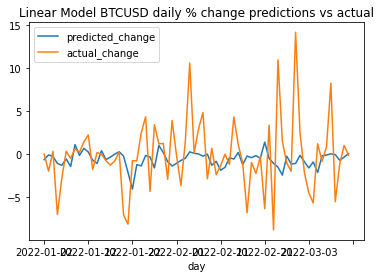

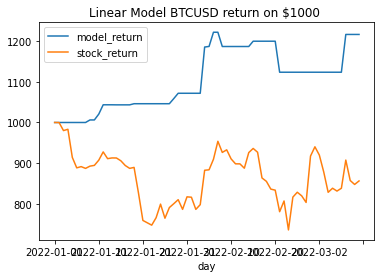

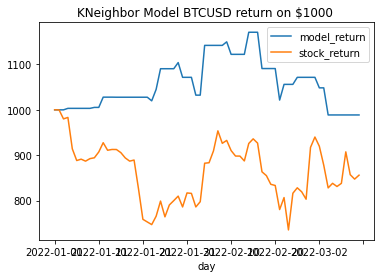

In [13]:
predict_crypto("BTCUSD")

stock turned $1000 into $702.5649197102987
model turned $1000 into $531.4071074776714
stock turned $1000 into $702.5649197102987
model turned $1000 into $758.57979339159


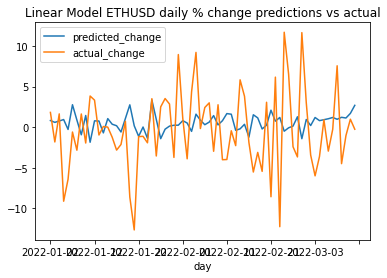

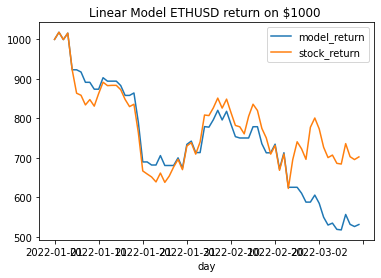

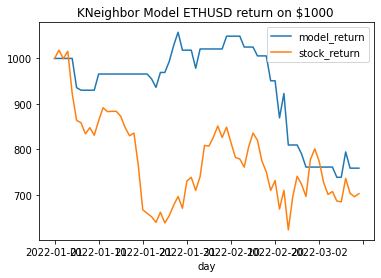

In [14]:
predict_crypto("ETHUSD")

stock turned $1000 into $726.5830866892035
model turned $1000 into $759.3069276017593
stock turned $1000 into $726.5830866892035
model turned $1000 into $973.8412452665111


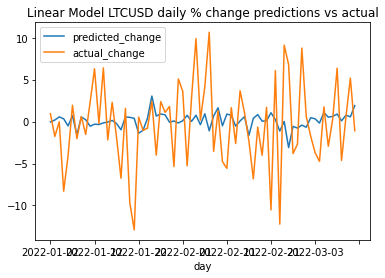

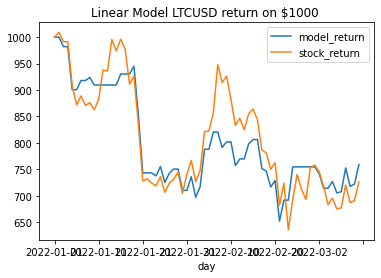

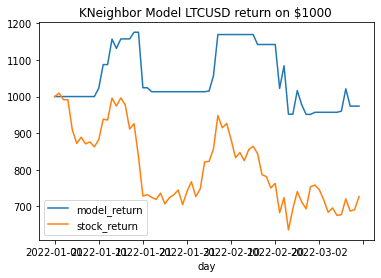

In [15]:
predict_crypto("LTCUSD")

stock turned $1000 into $931.0328231765703
model turned $1000 into $1034.7494420598844
stock turned $1000 into $931.0328231765703
model turned $1000 into $892.891218810787


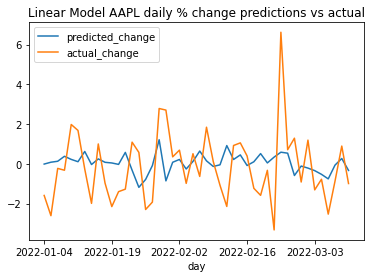

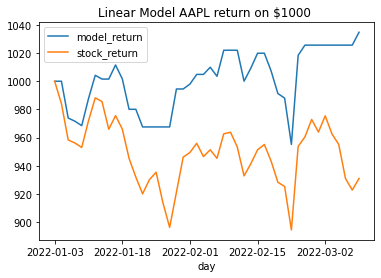

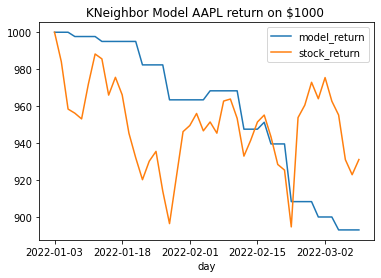

In [16]:
predict_stock("AAPL")

stock turned $1000 into $883.6499402416998
model turned $1000 into $974.4695476574576
stock turned $1000 into $883.6499402416998
model turned $1000 into $974.1697967772327


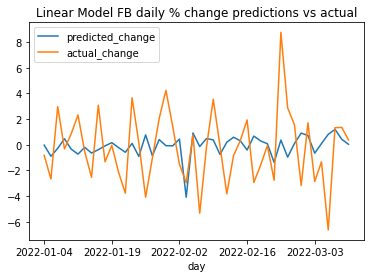

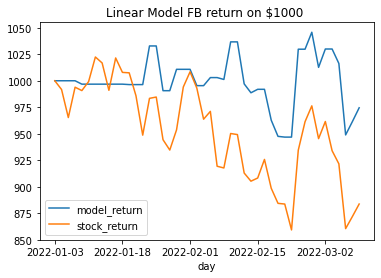

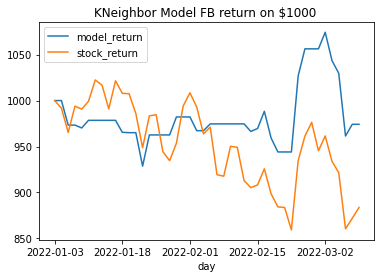

In [17]:
predict_stock("FB")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


stock turned $1000 into $810.418235596159
model turned $1000 into $825.1754367452751
stock turned $1000 into $810.418235596159
model turned $1000 into $933.9566863871646


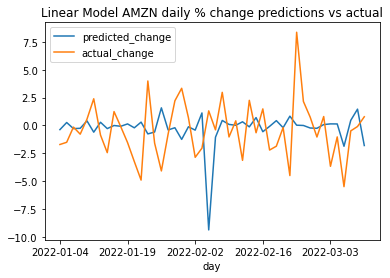

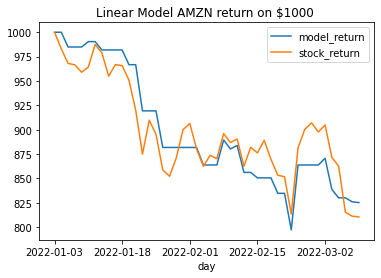

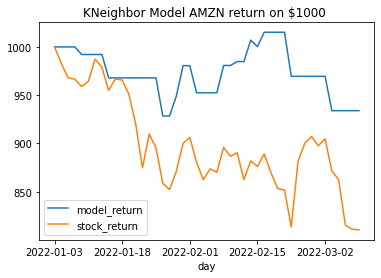

In [18]:
predict_stock("AMZN")

stock turned $1000 into $757.8879643047885
model turned $1000 into $873.4805470325232
stock turned $1000 into $757.8879643047885
model turned $1000 into $941.0969683141278


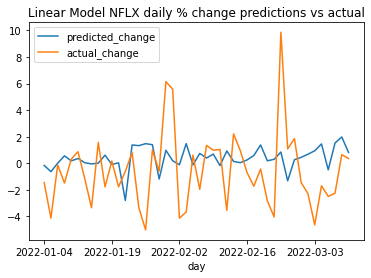

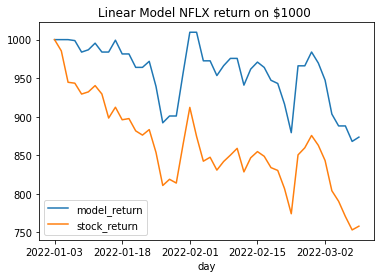

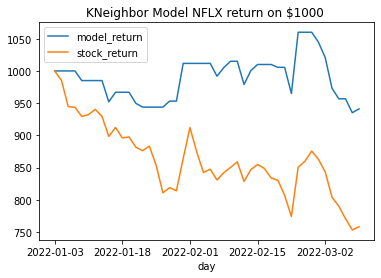

In [19]:
predict_stock("NFLX")

stock turned $1000 into $833.5704869558656
model turned $1000 into $899.1881833064012
stock turned $1000 into $833.5704869558656
model turned $1000 into $943.9671381238438


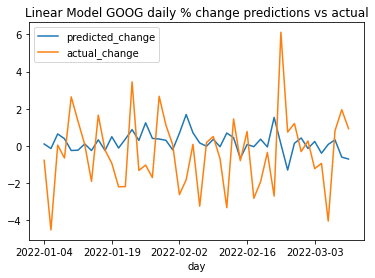

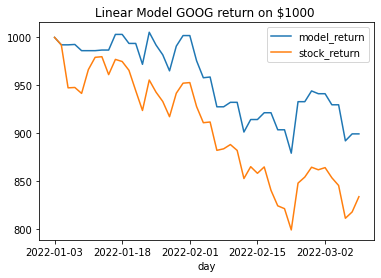

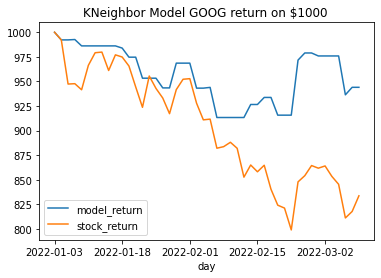

In [20]:
predict_stock("GOOG")